[View in Colaboratory](https://colab.research.google.com/github/MaxGhenis/random/blob/master/Testing_for_group_level_effects.ipynb)

# Testing for group-level effects

Simulate data with and without group-level and overall effects and test to recover estimates.

Specifically, simulate 20,000 observations, split evenly across 50 groups with half treatment half control (200 observations per cell). The groups have a N(0, 1) random additional slope with respect to treatment, fixed treatment effect of 1, and random noise of N(0, 1).

Start by calculating the effect and confidence interval for each group, then use ANOVA to determine the existence of a group effect.

Next calculate mixed effects models to do the same.

>[Testing for group-level effects](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=7fXyEoeeY7DV)

>>[Setup](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=wQt-q-MlZGKy)

>>[Generate data](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=EB9XvnvLYI-w)

>>[Per-group effects](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=t9mmHeHA4xTa)

>>[Regressions](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=YEvpcYD6dpMJ)

>>>[Simple linear model](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=yLQdKJunLw6Q)

>>>[Mixed effects](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=B_V6jY_ZuG3U)

>>>>[Extract random effects](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=QPtdWH0GfetI)

>>>[ANOVA](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=cX1hc4Ynu1_k)

>>>>[ANOVA from group statistics only](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=luhNmj06W8xl)

>>[Appendix](#updateTitle=true&folderId=0B1hDLsjCxwBXZjVKS0ZRMnZpX2c&scrollTo=xhpPnQvrtp4h)



## Setup

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from itertools import product
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [0]:
sns.set_style('white')
DPI = 100
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI

In [0]:
def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

## Generate data

TODO: Different n for each group/treatment slice.

In [0]:
N_GROUPS = 50
N_PER_GROUP = 200
OVERALL_EFFECT = 1

In [0]:
group_series = pd.Series(list(range(N_GROUPS)))  #, dtype='float32')
obs_series = pd.Series(list(range(N_PER_GROUP)))  #, dtype='float32')
bool_series = pd.Series(list({1, 0}))

df = expand_grid({'group': group_series,
                  'obs': obs_series, 
                  'in_treatment': bool_series,
                  'has_treatment_effect': bool_series,
                  'has_group_effect': bool_series})

group_effect = pd.DataFrame({'group': group_series,
                             'group_effect': np.random.randn(N_GROUPS)})

df = pd.merge(df, group_effect, on='group')
nrow = df.shape[0]
df['y'] = (
    df['in_treatment'] * df['has_treatment_effect'] * 
    (OVERALL_EFFECT + df['has_group_effect'] * df['group_effect']) +
    np.random.randn(nrow))

In [6]:
df.head(4)

,group,obs,in_treatment,has_treatment_effect,has_group_effect,group_effect,y
0,0,0,0,0,0,0.456753,0.274932
1,0,0,0,0,1,0.456753,0.330064
2,0,0,0,1,0,0.456753,0.881203
3,0,0,0,1,1,0.456753,0.074322


## Per-group effects

In [0]:
BYVARS = ['group', 'has_treatment_effect', 'has_group_effect']

In [0]:
def ci_halfwidth(x, y):
  cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
  return (cm.tconfint_diff(usevar='unequal')[1] - 
          cm.tconfint_diff(usevar='unequal')[0]) / 2

def summarize_general(x, y):
  return (x.mean() - y.mean(),
          ci_halfwidth(x, y),
          stats.ttest_ind(x, y)[0],
          stats.ttest_ind(x, y)[1])

def summarize(x):
  # Difference in means, 
  return summarize_general(x.loc[x['in_treatment'] == 1, 'y'],
                           x.loc[x['in_treatment'] == 0, 'y'])

In [0]:
groups = pd.merge(
    df.groupby(BYVARS, as_index=False).apply(summarize).reset_index(name='res'),
    group_effect, on='group')
# Can this be combined into one step?
groups[['diff_means', 'ci_halfwidth', 't', 'p']] = (
    groups['res'].apply(pd.Series))

Flag significance using Bonferroni correction.

In [0]:
groups['sig'] = groups['p'] <= (0.05 / N_GROUPS)

In [11]:
(groups[groups['sig']].groupby(['has_treatment_effect', 'has_group_effect'])
 .size())

has_treatment_effect  has_group_effect
1                     0                   50
                      1                   42
dtype: int64

Calculate standard error using normal approximation.

In [0]:
groups['se'] = groups['ci_halfwidth'] / 1.96

TODO: Estimate `n` per group using difference in means and CI halfwidth.

With group-level effects, the differences have higher spread.

Text(0.5,1,'Group distribution of differences in means (blue has group effect, green does not)')

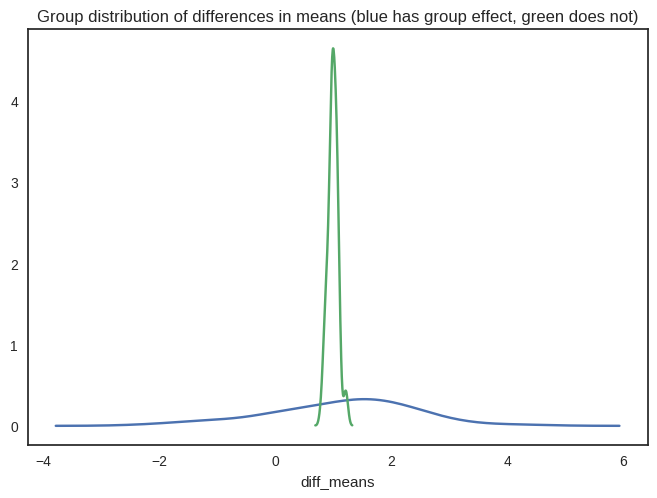

In [120]:
fig, ax = plt.subplots()
sns.distplot(groups.loc[(groups['has_treatment_effect'] == 1) & 
                        (groups['has_group_effect'] == 1), 
                        'diff_means'],
             hist=False, ax=ax)
sns.distplot(groups.loc[(groups['has_treatment_effect'] == 1) & 
                        (groups['has_group_effect'] == 0), 
                        'diff_means'],
             hist=False, ax=ax).set_title((
    'Group distribution of differences in means' +
    ' (blue has group effect, green does not)'))

Text(0.5,1,'Group distribution of differences in means (blue has group effect, green does not)')

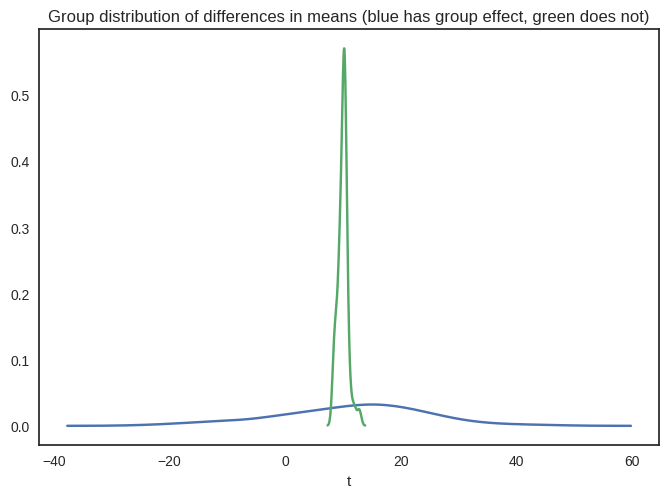

In [209]:
fig, ax = plt.subplots()
sns.distplot(groups.loc[(groups['has_treatment_effect'] == 1) & 
                        (groups['has_group_effect'] == 1), 
                        't'],
             hist=False, ax=ax)
sns.distplot(groups.loc[(groups['has_treatment_effect'] == 1) & 
                        (groups['has_group_effect'] == 0), 
                        't'],
             hist=False, ax=ax).set_title((
    'Group distribution of differences in means' +
    ' (blue has group effect, green does not)'))

### Test normality

Also test whether t statistics follow t distribution: https://stats.stackexchange.com/questions/126539/testing-whether-data-follows-t-distribution

In [216]:
print(stats.normaltest(groups.loc[(groups['has_treatment_effect'] == 1) & 
                            (groups['has_group_effect'] == 1), 
                            't']))
stats.normaltest(groups.loc[(groups['has_treatment_effect'] == 1) & 
                            (groups['has_group_effect'] == 0), 
                            't'])

NormaltestResult(statistic=1.570560219617966, pvalue=0.45599195607534704)


NormaltestResult(statistic=6.927477171406424, pvalue=0.03131247853321702)

In [217]:
print(stats.normaltest(groups.loc[(groups['has_treatment_effect'] == 1) & 
                            (groups['has_group_effect'] == 1), 
                            'diff_means']))
stats.normaltest(groups.loc[(groups['has_treatment_effect'] == 1) & 
                            (groups['has_group_effect'] == 0), 
                            'diff_means'])

NormaltestResult(statistic=2.1078235257090485, pvalue=0.34857154948937197)


NormaltestResult(statistic=1.3004517763881598, pvalue=0.5219278661010911)

Each group's estimate with CI.

In [81]:
groups.columns

Index(['group', 'has_treatment_effect', 'has_group_effect', 'res',
       'group_effect', 'diff_means', 'ci_halfwidth', 't', 'p', 'sig', 'sd'],
      dtype='object')

In [0]:
groups['diff_means_rank'] = (
    groups.groupby(['has_treatment_effect', 'has_group_effect'])['diff_means']
    .rank())

In [0]:
groups_t_g = groups[(groups['has_treatment_effect'] == 1) &
                    (groups['has_group_effect'] == 1)]
groups_t_ng = groups[(groups['has_treatment_effect'] == 1) &
                     (groups['has_group_effect'] == 0)]

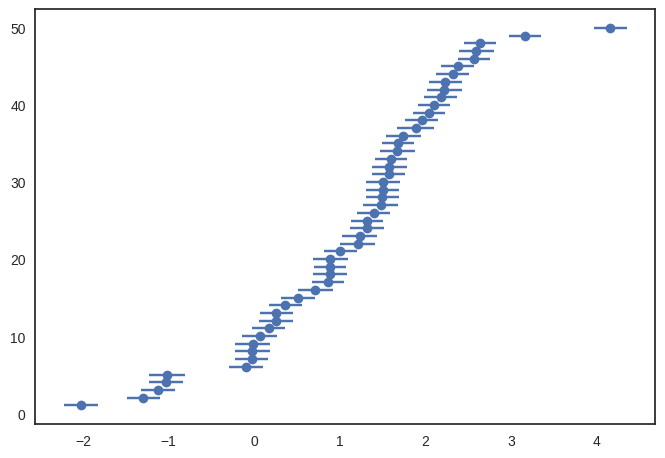

In [122]:
plt.errorbar(x=groups_t_g['diff_means'], y=groups_t_g['diff_means_rank'], 
             xerr=groups_t_g['ci_halfwidth'], fmt='o')

<Container object of 3 artists>

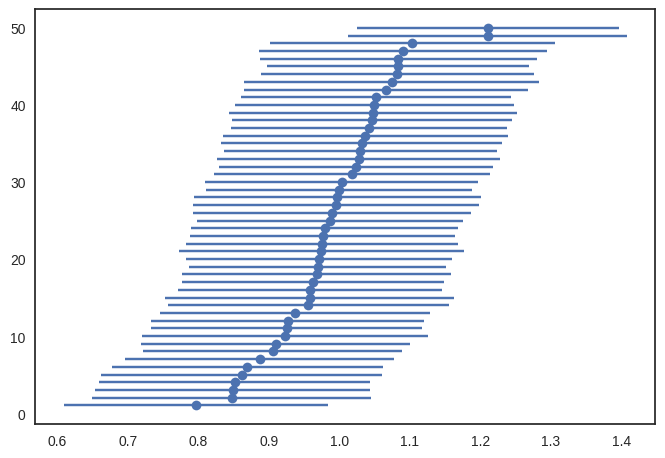

In [113]:
plt.errorbar(x=groups_t_ng['diff_means'], y=groups_t_ng['diff_means_rank'], 
             xerr=groups_t_ng['ci_halfwidth'], fmt='o')

## Regressions

### Simple linear model

In [18]:
lm_notreat_nogroup = smf.ols('y ~ in_treatment', 
                             data=df[(df['has_treatment_effect'] == 0) &
                                     (df['has_group_effect'] == 0)]).fit()
lm_notreat_nogroup.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.254
Date:                Thu, 25 Jan 2018   Prob (F-statistic):              0.263
Time:                        17:59:19   Log-Likelihood:                -28397.
No. Observations:               20000   AIC:                         5.680e+04
Df Residuals:                   19998   BIC:                         5.681e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0041      0.010      0.414      0.679      -0.015       0.024
in_treatment     0.0159      0.014      1.120      0.263      -0.012       0.044
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.423
Skew:                          -0.011   Prob(JB):                        0.809
Kurtosis:                       3.005   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No significant treatment coefficient: good!

In [19]:
lm_treat_nogroup = smf.ols('y ~ in_treatment', 
                           data=df[(df['has_treatment_effect'] == 1) &
                                   (df['has_group_effect'] == 0)]).fit()
lm_treat_nogroup.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     4977.
Date:                Thu, 25 Jan 2018   Prob (F-statistic):               0.00
Time:                        17:59:56   Log-Likelihood:                -28226.
No. Observations:               20000   AIC:                         5.646e+04
Df Residuals:                   19998   BIC:                         5.647e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0017      0.010     -0.175      0.861      -0.021       0.018
in_treatment     0.9902      0.014     70.549      0.000       0.963       1.018
==============================================================================
Omnibus:                        0.522   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.534
Skew:                          -0.012   Prob(JB):                        0.766
Kurtosis:                       2.991   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Significant treatment of close to the correct 1, with CI including 1.

### Mixed effects

Random slopes.

Unclear what **Coef.** and **Std.Err.** mean here, as `lme4` doesn't summarize this way. But in general these are small in absence of a random effect and large with coef/SE ~ 5 when the random effect is present, which seems right.



In [126]:
df_notreat_nogroup = df[(df['has_treatment_effect'] == 0) &
                        (df['has_group_effect'] == 0)]
with warnings.catch_warnings():  # Suppress ConvergenceWarnings.
  warnings.filterwarnings('ignore')
  rem_notreat_nogroup = smf.mixedlm('y ~ in_treatment', df_notreat_nogroup, 
                                    groups=df_notreat_nogroup['group'],
                                    re_formula='~ 0 + in_treatment').fit()
rem_notreat_nogroup.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: y          
No. Observations: 20000   Method:             REML       
No. Groups:       50      Scale:              1.0020     
Min. group size:  400     Likelihood:         -28404.8484
Max. group size:  400     Converged:          No         
Mean group size:  400.0                                  
---------------------------------------------------------
                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        0.004    0.010 0.414 0.679 -0.015  0.024
in_treatment     0.016    0.014 1.118 0.264 -0.012  0.044
in_treatment RE  0.000    0.001                          
=========================================================

"""

In [127]:
df_treat_nogroup = df[(df['has_treatment_effect'] == 0) &
                        (df['has_group_effect'] == 0)]
with warnings.catch_warnings():  # Suppress ConvergenceWarnings.
  warnings.filterwarnings('ignore')
  rem_treat_nogroup = smf.mixedlm('y ~ in_treatment', df_treat_nogroup, 
                                  groups=df_treat_nogroup['group'],
                                  re_formula='~ 0 + in_treatment').fit()
rem_treat_nogroup.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: y          
No. Observations: 20000   Method:             REML       
No. Groups:       50      Scale:              1.0020     
Min. group size:  400     Likelihood:         -28404.8484
Max. group size:  400     Converged:          No         
Mean group size:  400.0                                  
---------------------------------------------------------
                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        0.004    0.010 0.414 0.679 -0.015  0.024
in_treatment     0.016    0.014 1.118 0.264 -0.012  0.044
in_treatment RE  0.000    0.001                          
=========================================================

"""

In [128]:
df_notreat_group = df[(df['has_treatment_effect'] == 0) &
                      (df['has_group_effect'] == 1)]
with warnings.catch_warnings():  # Suppress ConvergenceWarnings.
  warnings.filterwarnings('ignore')
  rem_notreat_group = smf.mixedlm('y ~ in_treatment', df_notreat_group, 
                                    groups=df_notreat_group['group'],
                                    re_formula='~ 0 + in_treatment').fit()
rem_notreat_group.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM Dependent Variable: y          
No. Observations:  20000   Method:             REML       
No. Groups:        50      Scale:              1.0030     
Min. group size:   400     Likelihood:         -28415.9839
Max. group size:   400     Converged:          No         
Mean group size:   400.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.003    0.010  0.267 0.790 -0.017  0.022
in_treatment    -0.008    0.014 -0.559 0.576 -0.036  0.020
in_treatment RE  0.000    0.001                           
==========================================================

"""

In [129]:
df_treat_group = df[(df['has_treatment_effect'] == 1) &
                    (df['has_group_effect'] == 1)]
rem_treat_group = smf.mixedlm('y ~ in_treatment', df_treat_group, 
                              groups=df_treat_group['group'],
                              re_formula='~ 0 + in_treatment').fit()
rem_treat_group.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM Dependent Variable: y          
No. Observations:  20000   Method:             REML       
No. Groups:        50      Scale:              1.0017     
Min. group size:   400     Likelihood:         -28541.7368
Max. group size:   400     Converged:          Yes        
Mean group size:   400.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.010    0.010 -1.030 0.303 -0.030  0.009
in_treatment     1.141    0.173  6.589 0.000  0.802  1.481
in_treatment RE  1.490    0.302                           
==========================================================

"""

#### Extract random effects

In [0]:
group_effect_res = group_effect.copy()
re_df = pd.DataFrame.from_dict(rem_treat_group.random_effects, orient='index')
group_effect_res['re'] = re_df['in_treatment']

In [0]:
group_effect_res['re_rank'] = group_effect_res['re'].rank()

<Container object of 3 artists>

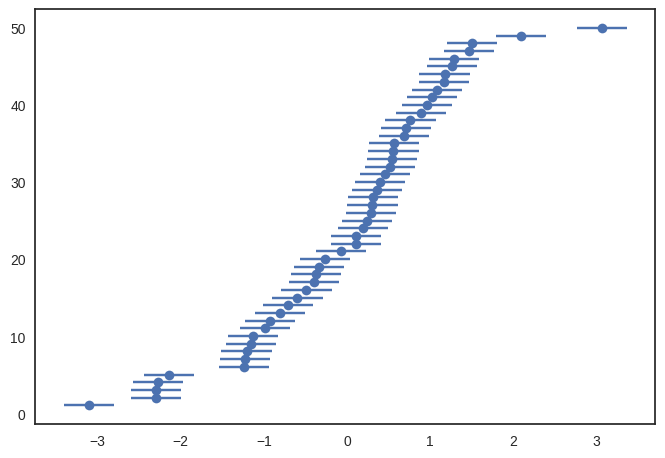

In [109]:
plt.errorbar(x=group_effect_res['re'], y=group_effect_res['re_rank'], 
             xerr=rem_treat_group.bse_re[0], fmt='o')

Correlation between true effect and random effect estimate.

In [123]:
np.corrcoef(group_effect_res['group_effect'], group_effect_res['re'])[0, 1]

0.9979544746036788

### ANOVA

In [63]:
df_treat_group.head()

,group,obs,in_treatment,has_treatment_effect,has_group_effect,group_effect,y
3,0,0,0,1,1,0.456753,0.074322
7,0,0,1,1,1,0.456753,1.442872
11,0,1,0,1,1,0.456753,-0.273384
15,0,1,1,1,1,0.456753,2.093466
19,0,2,0,1,1,0.456753,-0.161504


In [65]:
sm.stats.anova_lm(smf.ols('y ~ in_treatment + C(group)', 
                          data=df_treat_group).fit(),
                  typ=2)

,sum_sq,df,F,PR(>F)
C(group),7486.863039,49.0,112.184019,0.0
in_treatment,6511.324991,1.0,4780.755781,0.0
Residual,27170.269346,19949.0,NaN,NaN


In [68]:
sm.stats.anova_lm(smf.ols('y ~ in_treatment + C(group)', 
                          data=df_treat_nogroup).fit(),
                  typ=2)

,sum_sq,df,F,PR(>F)
C(group),47.167856,49.0,0.960622,0.551680
in_treatment,1.256956,1.0,1.254362,0.262735
Residual,19990.269069,19949.0,NaN,NaN


#### ANOVA from group statistics only

Consulting http://math.colgate.edu/math102/dlantz/examples/ANOVA/anova.html for formulas.

In [0]:
groups_t_g = groups[(groups['has_treatment_effect'] == 1) &
                    (groups['has_group_effect'] == 1)]

**SSE:**


SSi = si^2 * (ni - 1)

SSE = sum(SSi)

Given equal group sizes, this becomes:

SSE = n_groups \* (n_per_group - 1) * sum(si^2)

In [165]:
sse = N_GROUPS * (N_PER_GROUP - 1) * np.power(groups_t_g['se'], 2).sum()
sse

5013.528024855204

**SSG:** With equal group sizes, the overall effect equals the average effect over groups. SSG is then the squared difference between each group's effect and the average effect, multiplied by the total number of observations (group count * observations per group).

In [166]:
overall_effect = groups_t_g['diff_means'].mean()
ssg = N_GROUPS * N_PER_GROUP * np.power(groups_t_g['diff_means'] - 
                                        overall_effect,  2).sum()
ssg

723775.6568612925

DFE = N - I

In [0]:
dfe = N_GROUPS * N_PER_GROUP - N_GROUPS

DFG = I - 1

In [0]:
dfg = N_GROUPS - 1

MSE = SSE / DFE

MSG = SSG / DFG

In [169]:
mse = sse / dfe
msg = ssg / dfg
f = msg / mse
f

29314.839851205397

F-test. Call as [`stats.f.sf(f, dfn, dfd`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html) where `sf` is:

> Survival function (also defined as 1 - cdf, but sf is sometimes more accurate).

[dfn = dfg. dfd = dfe.](http://davidmlane.com/hyperstat/A107688.html)

In [170]:
stats.f.sf(f, dfg, dfe)

0.0

#### ANOVA from group stats when no group effect

In [172]:
groups_t_ng = groups[(groups['has_treatment_effect'] == 1) &
                     (groups['has_group_effect'] == 0)]
sse = N_GROUPS * ((N_PER_GROUP / 2) - 1) * np.power(groups_t_ng['se'], 2).sum()
overall_effect = groups_t_ng['diff_means'].mean()
ssg = N_GROUPS * (N_PER_GROUP / 2) * np.power(groups_t_ng['diff_means'] - 
                                        overall_effect,  2).sum()
dfe = N_GROUPS * (N_PER_GROUP / 2) - N_GROUPS
dfg = N_GROUPS - 1
mse = sse / dfe
msg = ssg / dfg
f = msg / mse
stats.f.sf(f, dfg, dfe)

0.0

In [0]:
def ftest_p(group_mean, group_se, group_n):
  # group_mean: Array of group means.
  # group_se: Array of group standard errors.
  # group_n: Array of group n-counts.
  n_groups = group_mean.len
  n = group_n.sum()
  sse = (np.power(group_se, 2) * group_n).sum()
  overall_mean = (group_mean * group_n).sum() / n
  ssg = N_GROUPS * N_PER_GROUP * np.power(groups_t_ng['diff_means'] - 
                                          overall_effect,  2).sum()
  dfe = n - n_groups
  dfg = n_groups - 1
mse = sse / dfe
msg = ssg / dfg
f = msg / mse
stats.f.sf(f, dfg, dfe)

In [175]:
ssg

1794.0233712336876

### Compare all means

Cartesian product of group-level stats, then compare means.

In [177]:
groups_t_g.columns

Index(['group', 'has_treatment_effect', 'has_group_effect', 'res',
       'group_effect', 'diff_means', 'ci_halfwidth', 't', 'p', 'sig', 'sd',
       'diff_means_rank', 'se', 'dummy'],
      dtype='object')

In [201]:
groups_t_g['dummy'] = 1
VARS = ['group', 'diff_means', 'se', 'dummy']
group_cart = pd.merge(groups_t_g[VARS], groups_t_g[VARS], on='dummy')
# Remove self-comparisons.
group_cart = group_cart[group_cart['group_x'] < group_cart['group_y']]
group_cart.columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Index(['group_x', 'diff_means_x', 'se_x', 'dummy', 'group_y', 'diff_means_y',
       'se_y'],
      dtype='object')

In [0]:
group_cart['se'] = np.sqrt(np.power(group_cart['se_x'], 2) + 
                           np.power(group_cart['se_y'], 2))
group_cart['t'] = ((group_cart['diff_means_y'] - group_cart['diff_means_x']) /
                   group_cart['se'])
group_cart['df'] = N_PER_GROUP - 1  # Conservative: min(n1-1, n2-1).
# Use normal approximation.
group_cart['p'] = stats.t.sf(np.abs(group_cart['t']), group_cart['df']) * 2
group_cart['sig'] = group_cart['p'] < (0.05 / group_cart.shape[0])

Share of pairwise comparisons that are significant using Bonferroni correction.

In [205]:
group_cart['sig'].mean()

0.7273469387755102

Same without a group effect.

In [207]:
groups_t_ng['dummy'] = 1
VARS = ['group', 'diff_means', 'se', 'dummy']
group_cart_ng = pd.merge(groups_t_ng[VARS], groups_t_ng[VARS], on='dummy')
# Remove self-comparisons.
group_cart_ng = group_cart_ng[group_cart_ng['group_x'] < 
                              group_cart_ng['group_y']]
group_cart_ng['se'] = np.sqrt(np.power(group_cart_ng['se_x'], 2) + 
                              np.power(group_cart_ng['se_y'], 2))
group_cart_ng['t'] = ((group_cart_ng['diff_means_y'] - 
                       group_cart_ng['diff_means_x']) /
                      group_cart_ng['se'])
group_cart_ng['df'] = N_PER_GROUP - 1  # Conservative: min(n1-1, n2-1).
group_cart_ng['p'] = stats.t.sf(np.abs(group_cart_ng['t']), 
                                group_cart_ng['df']) * 2
group_cart_ng['sig'] = group_cart_ng['p'] < (0.05 / group_cart_ng.shape[0])
group_cart_ng['sig'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.0

## Appendix

Linear model using `sklearn`, no p-values.

In [51]:
from sklearn import linear_model
regr_notreat_nogroup = linear_model.LinearRegression()
regr_notreat_nogroup.fit(df[['treatment']], df[['y_notreat_nogroup']])
regr_notreat_nogroup.coef_

array([[0.00375232]])

t-test for each group.

In [96]:
N = 100  # Observations per group.
tt_df = pd.DataFrame({'group': np.append(['A'] * N, ['B'] * N),
                      'x': np.random.randn(2 * N)})
tt_df['y'] = tt_df['x'] + np.random.randn(2 * N)
stats.ttest_ind(tt_df['x'], tt_df['y'])[0]

-0.3258633943050059

In [106]:
tt_df.groupby('group').apply(lambda x: x['y'].sum() / x['x'].sum())

group
A   -1.310939
B    0.544012
dtype: float64

In [0]:
cm = sms.CompareMeans(sms.DescrStatsW(tt_df['x']), sms.DescrStatsW(tt)

In [0]:
sms.CompareMeans()

In [97]:
def tt_from_df(df):
  return stats.ttest_ind(df['x'], df['y'])[0]
  
tt_df.groupby('group').apply(tt_from_df)

group
A   -0.292413
B   -0.167816
dtype: float64

In [104]:
res = pd.DataFrame()
res[['diff', 't', 'p']] = tt_df.groupby('group').apply(
    lambda df: pd.Series(df['y'].sum() / df['x'].sum(),
                         stats.ttest_ind(df['x'], df['y'])))

KeyError: ignored

In [103]:
res

,t,p
group,,
A,-0.292413,0.770277
B,-0.167816,0.866900
